In [1]:
%matplotlib inline
import gym
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from collections import deque
from IPython import display
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from scipy import stats
from training_methods import *
%load_ext autoreload
%autoreload

run_name = 0

In [2]:
# print(env.spec.max_episode_steps)

env = gym.make('CartPole-v1')
env.my_preprocess_input = lambda x: x

# env = gym.make('MountainCar-v0')
# env.my_preprocess_input = lambda x: x

# env = gym.make('Breakout-v0')
# env.my_preprocess_input = preprocess_input_breakout_v0

# env = gym.make('Pong-v0')
# env.my_preprocess_input = preprocess_input_pong_v0

# env.render(close=True)
# plt.imshow(env.render('rgb_array'))
print('Actions: {}, Observation space {}, {} parameters'.format(
    env.action_space.n, env.observation_space.shape, np.prod(env.observation_space.shape)))

[2017-08-19 09:58:58,149] Making new env: CartPole-v1


Actions: 2, Observation space (4,), 4 parameters


## Basic Actor-Critic

In [27]:
class ActorCriticAgent:
    def __init__(self, params):
        self.params = params
        self.memory = deque(maxlen=self.params.max_memory_size)
        self._build_actor_model()
        self._build_critic_model()

    def _build_actor_model(self):
        with tf.variable_scope('actor'):
            self.actor_x = tf.placeholder("float", [None, self.params.state_size], name="State")
            self.actor_y = tf.placeholder("float", [None], name="Target")
            self.actor_action = tf.placeholder(tf.int32, [None], name="Action")

            h0 = tf.contrib.layers.fully_connected(
                inputs=self.actor_x,
                num_outputs=20,
                activation_fn=tf.nn.relu,
                weights_initializer=tf.contrib.layers.xavier_initializer())

            h1 = tf.contrib.layers.fully_connected(
                inputs=h0,
                num_outputs=self.params.action_size,
                activation_fn=None,
                weights_initializer=tf.contrib.layers.xavier_initializer())
            
            self.actor_action_probs = tf.nn.softmax(h1)

            with tf.variable_scope('apply_actions'):
                sh = tf.shape(self.actor_action_probs)
                action_flat = tf.reshape(self.actor_action_probs, [-1])
                picked_flat = tf.reshape(tf.range(0, sh[0]) * sh[1], [-1]) + self.actor_action
                self.picked_action_probs = tf.reshape(tf.gather(action_flat, picked_flat), [sh[0]])

            self.actor_loss = tf.reduce_mean(-tf.log(1e-6 + self.picked_action_probs) * self.actor_y)
            self.actor_train_op = tf.train.RMSPropOptimizer(learning_rate=self.params.learning_rate, decay=0.99) \
                .minimize(self.actor_loss)

    def _build_critic_model(self):
        with tf.variable_scope('critic'):
            self.critic_x = tf.placeholder("float", [None, self.params.state_size], name="State")
            self.critic_y = tf.placeholder("float", [None], name="Target")

            h0 = tf.contrib.layers.fully_connected(
                inputs=self.critic_x,
                num_outputs=20,
                activation_fn=tf.nn.relu,
                weights_initializer=tf.contrib.layers.xavier_initializer())

            self.critic_value = tf.contrib.layers.fully_connected(
                inputs=h0,
                num_outputs=1,
                activation_fn=None,
                weights_initializer=tf.contrib.layers.xavier_initializer())
            
            self.critic_loss = tf.reduce_mean(tf.squared_difference(self.critic_value, self.critic_y))
            self.critic_train_op = tf.train.RMSPropOptimizer(learning_rate=self.params.learning_rate, decay=0.99) \
                .minimize(self.critic_loss)
            
    def remember(self, state, action, reward, next_state, frame):
        self.memory.append((state, action, reward, next_state))

    def act(self, state, frame):
        if np.random.rand() <= self.params.epsilon:
            return np.random.randint(0, self.params.action_size)
        return self.act_greedy(state, frame)
    
    def act_greedy(self, state, frame):
        act_probs = session.run(self.actor_action_probs, {self.actor_x: [state]})[0]
        return np.random.choice(np.arange(len(act_probs)), p=act_probs)
#         return np.argmax(act_values)

    def think(self, batch_size, episode):
        cnt = len(self.memory)
        States = np.zeros((cnt, self.params.state_size))
        ActorY = np.zeros((cnt))
        Actions = np.zeros((cnt), dtype=np.int32)
        CriticY = np.zeros((cnt))
        
        for i in range(cnt):
            state, action, reward, next_state = self.memory[i]
            
            values = session.run(self.critic_value, {self.critic_x: [state, next_state]})
            
            td = reward + self.params.gamma * values[1][0]
            ad = td - values[0][0]
            
            States[i], ActorY[i], CriticY[i], Actions[i] = state, ad, td, action

        P = np.random.permutation(cnt)
        for i in range(0, cnt, batch_size):
            batch_indexes = P[i: i + batch_size]
            states = States[batch_indexes]
            actorys = ActorY[batch_indexes]
            criticys = CriticY[batch_indexes]
            actions = Actions[batch_indexes]
            _ = session.run(self.actor_train_op,
                            {self.actor_x: states, self.actor_y: actorys, self.actor_action: actions})
            _ = session.run(self.critic_train_op,
                            {self.critic_x: states, self.critic_y: criticys})

State shape (4,), actions 2
Run: 12
episode: 5/100, reward 19.4, frames 12, exploration rate: 0.91
episode: 10/100, reward 20.0, frames 12, exploration rate: 0.79
episode: 15/100, reward 23.3, frames 35, exploration rate: 0.68
episode: 20/100, reward 23.0, frames 17, exploration rate: 0.58
episode: 25/100, reward 29.7, frames 82, exploration rate: 0.5
episode: 30/100, reward 47.8, frames 26, exploration rate: 0.43
episode: 35/100, reward 92.7, frames 267, exploration rate: 0.37
episode: 40/100, reward 199.7, frames 216, exploration rate: 0.32
episode: 45/100, reward 226.8, frames 165, exploration rate: 0.28
episode: 50/100, reward 197.7, frames 234, exploration rate: 0.24
episode: 55/100, reward 182.2, frames 99, exploration rate: 0.2
episode: 60/100, reward 126.5, frames 95, exploration rate: 0.18
episode: 65/100, reward 138.5, frames 275, exploration rate: 0.15
episode: 70/100, reward 127.1, frames 157, exploration rate: 0.13
episode: 75/100, reward 101.8, frames 71, exploration rate

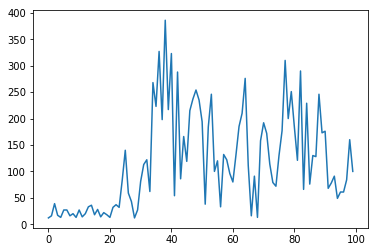

In [29]:
params = LearningParameters(env, episodes_count=100)
params.max_frame_in_episode = min(params.max_frame_in_episode, 10000)
params.epsilon_min = 0.05

if 'session' in locals():
    session.close()
    tf.reset_default_graph()
    if 'tf_writer' in locals():
        tf_writer.close()
config = tf.ConfigProto(device_count = {'GPU': 0})
session = tf.Session(config=config)
run_name += 1
print('Run: ' + str(run_name))

agent = ActorCriticAgent(params)

tf_writer = tf.summary.FileWriter('logs/run' + str(run_name), session.graph)

session.run(tf.global_variables_initializer())

agent, rewards = train_discounted_rewards(env, agent, params, normalize_rewards=True)
# agent, rewards = train_reward_is_time(env, agent, params)
# agent, rewards = train(env, agent, params)
plt.plot(rewards)